In [1]:
'''
COMPSCI 760 Group Project :Extending NCP to supervised learning - traffic dataset 
Found at https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Original NCP repo :https://github.com/mlech26l/keras-ncp
Original LTC repo :https://github.com/raminmh/liquid_time_constant_networks
'''

'\nCOMPSCI 760 Group Project :Extending NCP to supervised learning - traffic dataset \nFound at https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz\nOriginal NCP repo :https://github.com/mlech26l/keras-ncp\nOriginal LTC repo :https://github.com/raminmh/liquid_time_constant_networks\n'

In [2]:
import pandas
import numpy as np
import tensorflow as tf
from tensorflow import keras
import kerasncp
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [4]:
# change the directory here if needed
traffic_data = pandas.read_csv('./data/Metro_Interstate_Traffic_Volume.csv')

In [5]:
pandas.DataFrame.info(traffic_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
pandas.DataFrame.describe(traffic_data)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [7]:
import matplotlib.pyplot as plt
import datetime
import scipy.stats

## Data preprocessing - same as ltc

In [8]:
holiday = (traffic_data["holiday"].values == None).astype(np.float32)
temp = traffic_data["temp"].values.astype(np.float32)
temp -= np.mean(temp) #normalize temp by annual mean
rain = traffic_data["rain_1h"].values.astype(np.float32)
snow = traffic_data["snow_1h"].values.astype(np.float32)
clouds = traffic_data["clouds_all"].values.astype(np.float32)
date_time = traffic_data["date_time"].values
    #2012-10-02 13:00:00
date_time = [datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S") for d in date_time]
weekday = np.array([d.weekday() for d in date_time]).astype(np.float32)
noon = np.array([d.hour for d in date_time]).astype(np.float32)
noon = np.sin(noon*np.pi/24)

features = np.stack([holiday,temp,rain,snow,clouds,weekday,noon],axis=-1)

traffic_volume = traffic_data["traffic_volume"].values.astype(np.float32)
traffic_volume -= np.mean(traffic_volume) #normalize
traffic_volume /= np.std(traffic_volume) #normalize

### Plot the pdf of target variable - traffic_volume

<AxesSubplot:ylabel='Density'>

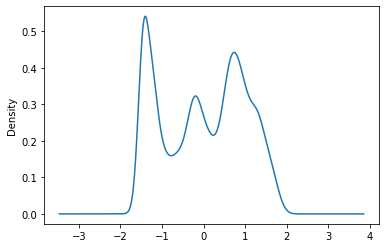

In [11]:
pandas.Series(traffic_volume).plot.kde()

In [10]:
#np.savetxt("preprocessed_traffic_data.csv", features, delimiter=",")

In [12]:
# change the directory here if needed
preprocessed_traffic_data = pandas.read_csv('/Users/adrianchoi/Desktop/760/ncp-time-series/preprocessed_traffic_data.csv')

In [13]:
pandas.DataFrame.describe(preprocessed_traffic_data)

,holiday,temp,rain,snow,clouds,weeday,noon
count,48204.0,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,0.0,-0.002409,0.334240,0.000222,49.362231,2.984980,0.633094
std,0.0,13.337713,44.783215,0.008168,39.015750,2.005941,0.309576
min,0.0,-281.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,-9.050000,0.000000,0.000000,1.000000,1.000000,0.383000
50%,0.0,1.240000,0.000000,0.000000,64.000000,3.000000,0.707000
75%,0.0,10.600000,0.000000,0.000000,90.000000,5.000000,0.924000
max,0.0,28.900000,9830.000000,0.510000,100.000000,6.000000,1.000000


In [14]:
def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)

In [15]:
train_x,train_y = cut_in_sequences(features,traffic_volume,32,inc=4)
train_x = np.stack(train_x,axis=1)
train_y = np.stack(train_y,axis=1)

total_seqs = train_x.shape[1]
print("Total number of training sequences: {}".format(total_seqs))
permutation = np.random.RandomState(23489).permutation(total_seqs)
valid_size = int(0.1*total_seqs)
test_size = int(0.15*total_seqs)
valid_x = train_x[:,permutation[:valid_size]]
valid_y = train_y[:,permutation[:valid_size]]
test_x = train_x[:,permutation[valid_size:valid_size+test_size]]
test_y = train_y[:,permutation[valid_size:valid_size+test_size]]
train_x = train_x[:,permutation[valid_size+test_size:]]
train_y = train_y[:,permutation[valid_size+test_size:]]


Total number of training sequences: 32


In [16]:
# cut the data in a sequence of length 32
train_x,train_y = cut_in_sequences(features,traffic_volume,32,inc=4)
train_x = np.stack(train_x,axis=1)
train_y = np.stack(train_y,axis=1)

## Experiments on randomly connected NCP

In [ ]:
neurons = [3,6,8,10]

# higher sparsity is likely to cause overfitting
sparsity = [0.2,0.3,0.4,0.5]

# epochs
epochs_n = 20

# batch size
batch_size_n = 16

# random seeds
random_seeds = [1111,1112,1113,1114,1115]

# a dict that stores all test loss, key = random_seed
all_test_loss_dic = {}

#### Note that for output graphs, please refer to the ncp-traffic-raw

In [ ]:
# Experiment with hyparameters - number of neurons, sparsity, random seeds
for r in random_seeds:
    all_test_loss_dic[r] = []
    for i in neurons:
        for j in sparsity: 
            print(str(i)+' neurons,'+' '+str(j)+' sparsity,'+' '+'random seed = '+str(r))
            arch = kerasncp.wirings.Random(i, 1, sparsity_level=j, random_seed = r)
            rnn_cell = LTCCell(arch)
            model = tf.keras.models.Sequential(
                [
                    tf.keras.Input((None, 7)),
                    tf.keras.layers.RNN(rnn_cell, return_sequences=True),
                ]
            )
            model.compile(
                optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
            )

            traffic_ncp_history = model.fit(x=train_x, y=train_y, batch_size=batch_size_n, epochs=epochs_n, validation_data=(valid_x,valid_y))
            test_loss = round(model.evaluate(test_x,test_y, batch_size_n),4)
            all_test_loss_dic[r].append(test_loss)
            loss_train = traffic_ncp_history.history['loss']
            loss_val = traffic_ncp_history.history['val_loss']
            epochs = range(1,epochs_n+1)
            plt.plot(epochs, loss_train, 'g', label='Training loss')
            plt.plot(epochs, loss_val, 'b', label='validation loss')
            plt.title('Training and Validation MSE loss ')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

## Experiments on NCP topology

#### Note that for output graphs, please refer to the ncp-traffic-raw

In [ ]:
## interneurons and command neurons for iteractions
param = [2,3,5]
for r in itertools.product(param, param):
    print('Inter neurons:',r[0],'command neurons:',r[1])
    arch = kerasncp.wirings.NCP(
    inter_neurons=r[0],  # Number of inter neurons
    command_neurons=r[1],  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=2,  # How many outgoing synapses has each sensory neuron
    inter_fanout=2,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=3,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=2,  # How many incoming synapses has each motor neuron
)
    rnn_cell = LTCCell(arch)
    model = tf.keras.models.Sequential(
            [
                tf.keras.Input((None, 7)),
                tf.keras.layers.RNN(rnn_cell, return_sequences=True),
            ]
        )
    model.compile(
            optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
        )
    traffic_ncp_history = model.fit(x=train_x, y=train_y, batch_size=batch_size_n, epochs=epochs_n, validation_data=(valid_x,valid_y))
    loss_train = traffic_ncp_history.history['loss']
    loss_val = traffic_ncp_history.history['val_loss']
    epochs = range(1,epochs_n+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation MSE loss ')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()